# Sentiment Analysis on Amazon Fine Food Reviews

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)

##### References : 
* [Data Source](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones)
* [Working with text Data in sklearn](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
* [Using pre-trained word embeddings in a Keras model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
* [Deep Learning with Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [Deep Learning, NLP, and Representations](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)
* [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
* [Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
* [Embedding and Tokenizer in Keras](http://www.orbifold.net/default/2017/01/10/embedding-and-tokenizer-in-keras/)

---
<a id="part1"></a>
## Part 1. Data Exploration

In [28]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline


import re
import nltk
from bs4 import BeautifulSoup
import lxml
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

The data set is available for download from [Kaggle](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones).

### Load Data

In [29]:



cnx = sqlite3.connect('/home/varuni/Documents/ML-LabProj/amazon-fine-food-reviews/database.sqlite')

df = pd.read_sql_query("SELECT * FROM Reviews", cnx)

### Data Exploration

In [30]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
#print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['ProductId']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Score']==3]["Score"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Score']>3]["Score"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Score']<3]["Score"].count()/len(df)*100))

Summary statistics of numerical features : 
                   Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.3512

### Data Visualization 

Text(0,0.5,'Count')

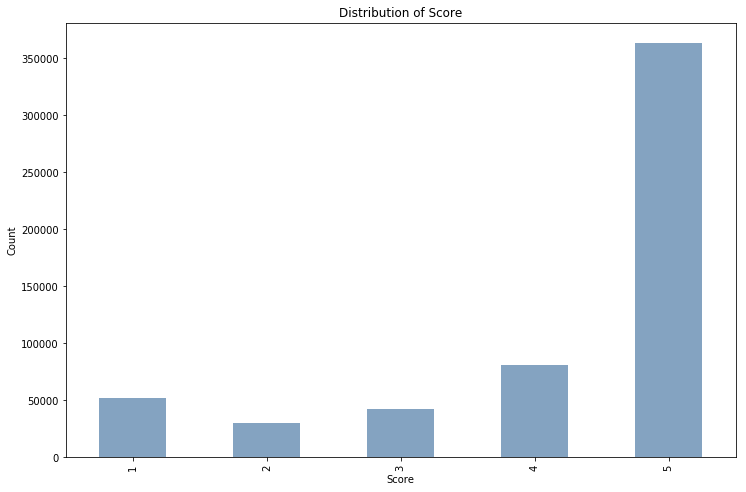

In [31]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Score'].value_counts().sort_index().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Count')

Text(0.5,1,'Number of Reviews for Top 50 Products')

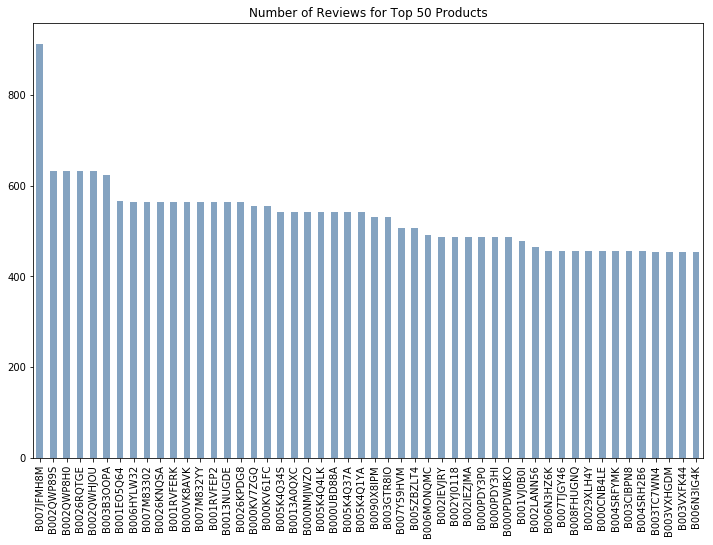

In [32]:
# Plot number of reviews for top 50 products
products = df["ProductId"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title("Number of Reviews for Top 50 Products")

Text(0,0.5,'Count')

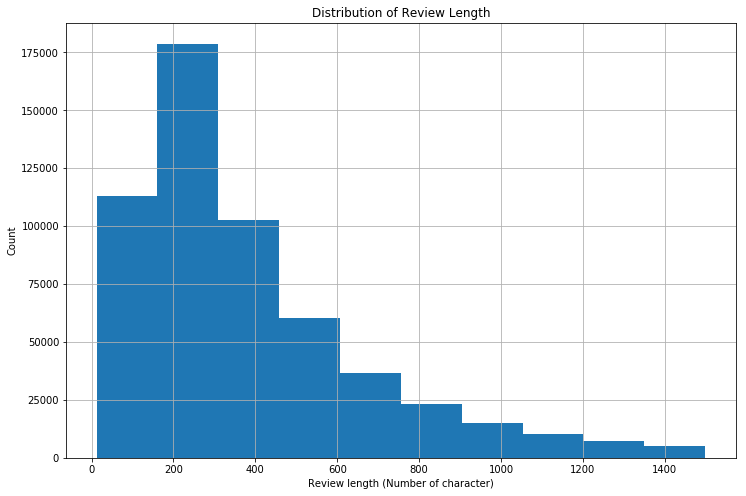

In [33]:
# Plot distribution of review length
review_length = df["Text"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [34]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Score'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
11214,11215,B001KVPC0G,A1FJEIB7HQ22ME,Marty Whitman,5,5,5,1334188800,Yes!!!,I could live off of these! I'm not kidding. Th...,1
222079,222080,B000OJ1H36,A1P59RM84ZIA0C,trail mix junkie,0,0,5,1325808000,Tropical Trail Mix,I found this product in a local grocery store ...,1
251082,251083,B0009F8JRC,ASPAJS6WD8CWY,Lanette Hawkes,1,2,5,1223510400,Great Gummies!,My young son is taking Chinese in school and w...,1
317731,317732,B005K4Q1RW,A2020KL55SYZ4U,Paula E. Williams,0,0,5,1334534400,I'm addicted to this!,I love Grove Square Spiced Apple Cider Cups (s...,1
404652,404653,B00153C4B4,A22BGI38W7Q9X9,PracticalWaysToSaveMoney,0,0,2,1332547200,"Tastes Eh, Very Expensive",This is probably my shortest review but there'...,0


### Train Test Split 

In [35]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 47393 training examples and 5266 validation examples. 

Show a review in the training set : 
 I am the companion to a small dog of unknown age and breed who has been troubled with a tender tummy for a few years.  Her vet has tons of medications to give her, but I don't need any of them since I tried the Wellness brand dry dog food and the moist.<br /><br />All her problems gave gone away.  It is amazing.  She has not been to the vet since her last yearly checkup.


---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [36]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'html.parser').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [37]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 i am the companion to a small dog of unknown age and breed who has been troubled with a tender tummy for a few years her vet has tons of medications to give her but i don t need any of them since i tried the wellness brand dry dog food and the moist all her problems gave gone away it is amazing she has not been to the vet since her last yearly checkup


### CountVectorizer with Multinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [38]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 40602 

Show some feature names : 
 ['aa', 'alo', 'asparatame', 'behaviorist', 'bourbon', 'cancelled', 'chezus', 'columnist', 'counseletmillard', 'deceiving', 'disapponted', 'earily', 'ethylene', 'fibrous', 'freind', 'glutens', 'halfdead', 'horked', 'ingested', 'jovial', 'lcd', 'lyrically', 'merlotte', 'much', 'np', 'outlawed', 'penning', 'pomace', 'provides', 'recommendthat', 'rhode', 'scallops', 'shone', 'sold', 'steviosides', 'sweaty', 'themgot', 'treatable', 'unshelled', 'walnut', 'wouoldn']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [40]:
def modelTrainEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on train set: {:.4f}".format(accuracy_score(y_train, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_train, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_train, predictions))
    print("\nConfusion Matrix : \n",metrics.confusion_matrix(y_train, predictions) )

In [41]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_train_cleaned))
modelTrainEvaluation(predictions)
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on train set: 0.9308

AUC score : 0.8512

Classification report : 
              precision    recall  f1-score   support

          0       0.81      0.73      0.77      7463
          1       0.95      0.97      0.96     39930

avg / total       0.93      0.93      0.93     47393


Confusion Matrix : 
 [[ 5485  1978]
 [ 1303 38627]]

Accuracy on validation set: 0.9064

AUC score : 0.7859

Classification report : 
              precision    recall  f1-score   support

          0       0.73      0.61      0.67       805
          1       0.93      0.96      0.95      4461

avg / total       0.90      0.91      0.90      5266


Confusion Matrix : 
 [[ 493  312]
 [ 181 4280]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [42]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 13112 

Show some feature names : 
 ['00', 'avoided', 'categories', 'crunchier', 'emails', 'gatorade', 'induced', 'maggi', 'offspring', 'proclaims', 'saltiest', 'ss', 'toward', 'xxx']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'worst' 'disappointed' 'terrible' 'awful' 'horrible'
 'disappointing' 'money' 'weak' 'disappointment']

Top 10 features with largest coefficients : 
['great' 'best' 'delicious' 'love' 'good' 'perfect' 'excellent' 'nice'
 'loves' 'wonderful']


In [44]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_train_cleaned))
modelTrainEvaluation(predictions)
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on train set: 0.9330

AUC score : 0.8127

Classification report : 
              precision    recall  f1-score   support

          0       0.91      0.64      0.75      7463
          1       0.94      0.99      0.96     39930

avg / total       0.93      0.93      0.93     47393


Confusion Matrix : 
 [[ 4755  2708]
 [  465 39465]]

Accuracy on validation set: 0.9220

AUC score : 0.7809

Classification report : 
              precision    recall  f1-score   support

          0       0.87      0.58      0.69       805
          1       0.93      0.98      0.96      4461

avg / total       0.92      0.92      0.92      5266


Confusion Matrix : 
 [[ 465  340]
 [  71 4390]]


### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [27]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f5e3b5ec390, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/varuni/anaconda3/envs/mlearn/lib/python3.6...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/varuni.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f5e3b5ec390, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/varuni/anaconda3/envs/mlearn/lib/python3.6...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/varuni.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 25, 19, 53, 42, 880470, tzinfo=tzutc()), 'msg_id': 'ca9f86497b4a49e58e32ca628f764f90', 'msg_type': 'execute_request', 'session': '5ed8a4dc1cfa4f90be0f39066c7911bf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ca9f86497b4a49e58e32ca628f764f90', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'5ed8a4dc1cfa4f90be0f39066c7911bf']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 25, 19, 53, 42, 880470, tzinfo=tzutc()), 'msg_id': 'ca9f86497b4a49e58e32ca628f764f90', 'msg_type': 'execute_request', 'session': '5ed8a4dc1cfa4f90be0f39066c7911bf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ca9f86497b4a49e58e32ca628f764f90', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'5ed8a4dc1cfa4f90be0f39066c7911bf'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 25, 19, 53, 42, 880470, tzinfo=tzutc()), 'msg_id': 'ca9f86497b4a49e58e32ca628f764f90', 'msg_type': 'execute_request', 'session': '5ed8a4dc1cfa4f90be0f39066c7911bf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ca9f86497b4a49e58e32ca628f764f90', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Building a pipeline\nestimators = [("tfidf", Tf...dict(X_test_cleaned)\nmodelEvaluation(predictions)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-27-c447105a4670>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f5da5d87ac8, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f5dcd2200c0, file "<ipython-input-27-c447105a4670>", line 14>
        result = <ExecutionResult object at 7f5da5d87ac8, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f5dcd2200c0, file "<ipython-input-27-c447105a4670>", line 14>, result=<ExecutionResult object at 7f5da5d87ac8, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f5dcd2200c0, file "<ipython-input-27-c447105a4670>", line 14>
        self.user_global_ns = {'Activation': <class 'keras.layers.core.Activation'>, 'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'Convolution1D': <class 'keras.layers.convolutional.Conv1D'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'Embedding': <class 'keras.layers.embeddings.Embedding'>, 'GRU': <class 'keras.layers.recurrent.GRU'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, ...}
        self.user_ns = {'Activation': <class 'keras.layers.core.Activation'>, 'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'Convolution1D': <class 'keras.layers.convolutional.Conv1D'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'Embedding': <class 'keras.layers.embeddings.Embedding'>, 'GRU': <class 'keras.layers.recurrent.GRU'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/varuni/Downloads/Senti-master/<ipython-input-27-c447105a4670> in <module>()
      9           "tfidf__max_features": [1000, None], #max features
     10           "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
     11           "tfidf__stop_words": [None, "english"]} #use stopwords or don't
     12 
     13 grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
---> 14 grid.fit(X_train_cleaned, y_train)
     15 print("The best paramenter set is : \n", grid.best_params_)
     16 
     17 
     18 # Evaluate on the validaton set

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...ore='warn',
       scoring='accuracy', verbose=0), X=[['tried', 'lot', 'v', 'chips', 'best', 'real', 'sea', 'salt', 'real', 'vinegar', 'mouth', 'watering', 'flavor', 'crispiness', 'faint', 'heart', 'flavor', 'authentic'], ['get', 'small', 'bottles', 'tasty', 'honey', 'expecting', 'get', 'bigger', 'bottles', 'looking', 'best', 'deals', 'purchase', 'online', 'honest', 'get', 'similar', 'price', 'local', 'supermarket', ...], ['great', 'tasting', 'coffee', 'great', 'price', 'fast', 'shipping', 'amazon', 'prime', 'would', 'highly', 'recommend', 'coffee', 'really', 'enjoy', 'coffee', 'every', 'morning', 'morning', 'joe'], ['drinking', 'green', 'tea', 'years', 'thought', 'would', 'try', 'something', 'little', 'different', 'product', 'makes', 'wonderful', 'cup', 'tea', 'shared', 'people', 'one', 'exception', 'everyone', ...], ['tried', 'chicken', 'cheese', 'peanut', 'butter', 'sometimes', 'cookies', 'small', 'hearts', 'times', 'large', 'hearts', 'chunks', 'oatmeal', 'stuck', 'smaller', 'cookies', 'tender', 'large', 'ones', ...], ['like', 'pre', 'mix', 'herbs', 'flour', 'bread', 'crumbs', 'instruction', 'making', 'mix', 'except', 'mix', 'already', 'done', 'dump', 'mix', 'ziploc', 'bag', 'put', 'one', ...], ['buyer', 'beware', 'caused', 'severe', 'intestinal', 'bleeding', 'inflamed', 'stomach', 'lining', 'two', 'toy', 'poodles', 'taken', 'emergency', 'nearest', 'animal', 'hospital', 'vet', 'bill', 'cost', ...], ['syrup', 'makes', 'excellent', 'mango', 'iced', 'tea', 'brew', 'regular', 'iced', 'tea', 'sweeten', 'little', 'use', 'much', 'syrup', 'add', 'monin', 'mango', 'syrup', 'taste', ...], ['perfect', 'crispy', 'cookie', 'texture', 'delicous', 'filling', 'also', 'make', 'chocolate', 'cookie', 'version', 'prefer', 'vanilla', 'reminds', 'old', 'fudge', 'town', 'cookies', 'made'], ['ingredients', 'sugar', 'glucose', 'syrup', 'solids', 'coca', 'processed', 'alkali', 'partially', 'hydrogenated', 'vegetable', 'oil', 'may', 'contain', 'coconut', 'soybean', 'sunflower', 'palm', 'canola', 'nonfat', ...], ['companion', 'small', 'dog', 'unknown', 'age', 'breed', 'troubled', 'tender', 'tummy', 'years', 'vet', 'tons', 'medications', 'give', 'need', 'since', 'tried', 'wellness', 'brand', 'dry', ...], ['best', 'pasta', 'kit', 'ever', 'tried', 'local', 'kroger', 'stopped', 'carrying', 'years', 'ago', 'seriously', 'bummed', 'throw', 'diced', 'tomatoes', 'winner', 'go', 'covered', 'dish', ...], ['trying', 'couscous', 'amazon', 'site', 'hopes', 'high', 'surprised', 'brand', 'good', 'packaging', 'awkward', 'though', 'resealable', 'understand', 'references', 'israel', 'product', 'description', 'israeli', 'pearl', ...], ['stonehouse', 'extra', 'virgin', 'blood', 'orange', 'olive', 'oil', 'exciting', 'ingredient', 'added', 'kitchen', 'staples', 'since', 'discovered', 'eden', 'hot', 'pepper', 'seamame', 'oil', 'five', ...], ['always', 'lookout', 'good', 'salsa', 'prefer', 'salsas', 'deliver', 'robust', 'flavor', 'heat', 'sadly', 'herdez', 'fails', 'accounts', 'first', 'impression', 'pour', 'salsa', 'bowl', 'much', ...], ['tried', 'tea', 'first', 'time', 'restaurant', 'st', 'time', 'iced', 'cool', 'refreshing', 'nd', 'time', 'hot', 'mmmm', 'taste', 'leans', 'ginger', 'side', 'lemon', 'tried', ...], ['apple', 'chips', 'taste', 'good', 'good', 'month', 'old', 'loves', 'eat', 'regular', 'apples', 'eat', 'strawberry', 'ones', 'tart', 'like', 'banana', 'chips', 'kind', 'hard', ...], ['cats', 'love', 'feline', 'greenies', 'known', 'picky', 'treats', 'like', 'come', 'different', 'flavors', 'far', 'cats', 'liked'], ['soft', 'type', 'flavorful', 'plenty', 'chew', 'tough', 'flavors', 'little', 'vague', 'really', 'delicious'], ['perfect', 'stuffing', 'toys', 'like', 'kongs', 'types', 'smaller', 'holes', 'put', 'round', 'square', 'ones', 'aussie', 'large', 'regularly', 'shaped', 'kong', 'biscuit', 'looking', 'ones', ...], ...], y=26101     1
87287     1
208955    1
136615    1
...   1
Name: Sentiment, Length: 47393, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X = [['tried', 'lot', 'v', 'chips', 'best', 'real', 'sea', 'salt', 'real', 'vinegar', 'mouth', 'watering', 'flavor', 'crispiness', 'faint', 'heart', 'flavor', 'authentic'], ['get', 'small', 'bottles', 'tasty', 'honey', 'expecting', 'get', 'bigger', 'bottles', 'looking', 'best', 'deals', 'purchase', 'online', 'honest', 'get', 'similar', 'price', 'local', 'supermarket', ...], ['great', 'tasting', 'coffee', 'great', 'price', 'fast', 'shipping', 'amazon', 'prime', 'would', 'highly', 'recommend', 'coffee', 'really', 'enjoy', 'coffee', 'every', 'morning', 'morning', 'joe'], ['drinking', 'green', 'tea', 'years', 'thought', 'would', 'try', 'something', 'little', 'different', 'product', 'makes', 'wonderful', 'cup', 'tea', 'shared', 'people', 'one', 'exception', 'everyone', ...], ['tried', 'chicken', 'cheese', 'peanut', 'butter', 'sometimes', 'cookies', 'small', 'hearts', 'times', 'large', 'hearts', 'chunks', 'oatmeal', 'stuck', 'smaller', 'cookies', 'tender', 'large', 'ones', ...], ['like', 'pre', 'mix', 'herbs', 'flour', 'bread', 'crumbs', 'instruction', 'making', 'mix', 'except', 'mix', 'already', 'done', 'dump', 'mix', 'ziploc', 'bag', 'put', 'one', ...], ['buyer', 'beware', 'caused', 'severe', 'intestinal', 'bleeding', 'inflamed', 'stomach', 'lining', 'two', 'toy', 'poodles', 'taken', 'emergency', 'nearest', 'animal', 'hospital', 'vet', 'bill', 'cost', ...], ['syrup', 'makes', 'excellent', 'mango', 'iced', 'tea', 'brew', 'regular', 'iced', 'tea', 'sweeten', 'little', 'use', 'much', 'syrup', 'add', 'monin', 'mango', 'syrup', 'taste', ...], ['perfect', 'crispy', 'cookie', 'texture', 'delicous', 'filling', 'also', 'make', 'chocolate', 'cookie', 'version', 'prefer', 'vanilla', 'reminds', 'old', 'fudge', 'town', 'cookies', 'made'], ['ingredients', 'sugar', 'glucose', 'syrup', 'solids', 'coca', 'processed', 'alkali', 'partially', 'hydrogenated', 'vegetable', 'oil', 'may', 'contain', 'coconut', 'soybean', 'sunflower', 'palm', 'canola', 'nonfat', ...], ['companion', 'small', 'dog', 'unknown', 'age', 'breed', 'troubled', 'tender', 'tummy', 'years', 'vet', 'tons', 'medications', 'give', 'need', 'since', 'tried', 'wellness', 'brand', 'dry', ...], ['best', 'pasta', 'kit', 'ever', 'tried', 'local', 'kroger', 'stopped', 'carrying', 'years', 'ago', 'seriously', 'bummed', 'throw', 'diced', 'tomatoes', 'winner', 'go', 'covered', 'dish', ...], ['trying', 'couscous', 'amazon', 'site', 'hopes', 'high', 'surprised', 'brand', 'good', 'packaging', 'awkward', 'though', 'resealable', 'understand', 'references', 'israel', 'product', 'description', 'israeli', 'pearl', ...], ['stonehouse', 'extra', 'virgin', 'blood', 'orange', 'olive', 'oil', 'exciting', 'ingredient', 'added', 'kitchen', 'staples', 'since', 'discovered', 'eden', 'hot', 'pepper', 'seamame', 'oil', 'five', ...], ['always', 'lookout', 'good', 'salsa', 'prefer', 'salsas', 'deliver', 'robust', 'flavor', 'heat', 'sadly', 'herdez', 'fails', 'accounts', 'first', 'impression', 'pour', 'salsa', 'bowl', 'much', ...], ['tried', 'tea', 'first', 'time', 'restaurant', 'st', 'time', 'iced', 'cool', 'refreshing', 'nd', 'time', 'hot', 'mmmm', 'taste', 'leans', 'ginger', 'side', 'lemon', 'tried', ...], ['apple', 'chips', 'taste', 'good', 'good', 'month', 'old', 'loves', 'eat', 'regular', 'apples', 'eat', 'strawberry', 'ones', 'tart', 'like', 'banana', 'chips', 'kind', 'hard', ...], ['cats', 'love', 'feline', 'greenies', 'known', 'picky', 'treats', 'like', 'come', 'different', 'flavors', 'far', 'cats', 'liked'], ['soft', 'type', 'flavorful', 'plenty', 'chew', 'tough', 'flavors', 'little', 'vague', 'really', 'delicious'], ['perfect', 'stuffing', 'toys', 'like', 'kongs', 'types', 'smaller', 'holes', 'put', 'round', 'square', 'ones', 'aussie', 'large', 'regularly', 'shaped', 'kong', 'biscuit', 'looking', 'ones', ...], ...]
        y = 26101     1
87287     1
208955    1
136615    1
...   1
Name: Sentiment, Length: 47393, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Thu Apr 26 01:23:44 2018
PID: 4539       Python 3.6.4: /home/varuni/anaconda3/envs/mlearn/bin/python
...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('tfidf', Tfid...0.0001,
          verbose=0, warm_start=False))]), [['tried', 'lot', 'v', 'chips', 'best', 'real', 'sea', 'salt', 'real', 'vinegar', 'mouth', 'watering', 'flavor', 'crispiness', 'faint', 'heart', 'flavor', 'authentic'], ['get', 'small', 'bottles', 'tasty', 'honey', 'expecting', 'get', 'bigger', 'bottles', 'looking', 'best', 'deals', 'purchase', 'online', 'honest', 'get', 'similar', 'price', 'local', 'supermarket', ...], ['great', 'tasting', 'coffee', 'great', 'price', 'fast', 'shipping', 'amazon', 'prime', 'would', 'highly', 'recommend', 'coffee', 'really', 'enjoy', 'coffee', 'every', 'morning', 'morning', 'joe'], ['drinking', 'green', 'tea', 'years', 'thought', 'would', 'try', 'something', 'little', 'different', 'product', 'makes', 'wonderful', 'cup', 'tea', 'shared', 'people', 'one', 'exception', 'everyone', ...], ['tried', 'chicken', 'cheese', 'peanut', 'butter', 'sometimes', 'cookies', 'small', 'hearts', 'times', 'large', 'hearts', 'chunks', 'oatmeal', 'stuck', 'smaller', 'cookies', 'tender', 'large', 'ones', ...], ['like', 'pre', 'mix', 'herbs', 'flour', 'bread', 'crumbs', 'instruction', 'making', 'mix', 'except', 'mix', 'already', 'done', 'dump', 'mix', 'ziploc', 'bag', 'put', 'one', ...], ['buyer', 'beware', 'caused', 'severe', 'intestinal', 'bleeding', 'inflamed', 'stomach', 'lining', 'two', 'toy', 'poodles', 'taken', 'emergency', 'nearest', 'animal', 'hospital', 'vet', 'bill', 'cost', ...], ['syrup', 'makes', 'excellent', 'mango', 'iced', 'tea', 'brew', 'regular', 'iced', 'tea', 'sweeten', 'little', 'use', 'much', 'syrup', 'add', 'monin', 'mango', 'syrup', 'taste', ...], ['perfect', 'crispy', 'cookie', 'texture', 'delicous', 'filling', 'also', 'make', 'chocolate', 'cookie', 'version', 'prefer', 'vanilla', 'reminds', 'old', 'fudge', 'town', 'cookies', 'made'], ['ingredients', 'sugar', 'glucose', 'syrup', 'solids', 'coca', 'processed', 'alkali', 'partially', 'hydrogenated', 'vegetable', 'oil', 'may', 'contain', 'coconut', 'soybean', 'sunflower', 'palm', 'canola', 'nonfat', ...], ['companion', 'small', 'dog', 'unknown', 'age', 'breed', 'troubled', 'tender', 'tummy', 'years', 'vet', 'tons', 'medications', 'give', 'need', 'since', 'tried', 'wellness', 'brand', 'dry', ...], ['best', 'pasta', 'kit', 'ever', 'tried', 'local', 'kroger', 'stopped', 'carrying', 'years', 'ago', 'seriously', 'bummed', 'throw', 'diced', 'tomatoes', 'winner', 'go', 'covered', 'dish', ...], ['trying', 'couscous', 'amazon', 'site', 'hopes', 'high', 'surprised', 'brand', 'good', 'packaging', 'awkward', 'though', 'resealable', 'understand', 'references', 'israel', 'product', 'description', 'israeli', 'pearl', ...], ['stonehouse', 'extra', 'virgin', 'blood', 'orange', 'olive', 'oil', 'exciting', 'ingredient', 'added', 'kitchen', 'staples', 'since', 'discovered', 'eden', 'hot', 'pepper', 'seamame', 'oil', 'five', ...], ['always', 'lookout', 'good', 'salsa', 'prefer', 'salsas', 'deliver', 'robust', 'flavor', 'heat', 'sadly', 'herdez', 'fails', 'accounts', 'first', 'impression', 'pour', 'salsa', 'bowl', 'much', ...], ['tried', 'tea', 'first', 'time', 'restaurant', 'st', 'time', 'iced', 'cool', 'refreshing', 'nd', 'time', 'hot', 'mmmm', 'taste', 'leans', 'ginger', 'side', 'lemon', 'tried', ...], ['apple', 'chips', 'taste', 'good', 'good', 'month', 'old', 'loves', 'eat', 'regular', 'apples', 'eat', 'strawberry', 'ones', 'tart', 'like', 'banana', 'chips', 'kind', 'hard', ...], ['cats', 'love', 'feline', 'greenies', 'known', 'picky', 'treats', 'like', 'come', 'different', 'flavors', 'far', 'cats', 'liked'], ['soft', 'type', 'flavorful', 'plenty', 'chew', 'tough', 'flavors', 'little', 'vague', 'really', 'delicious'], ['perfect', 'stuffing', 'toys', 'like', 'kongs', 'types', 'smaller', 'holes', 'put', 'round', 'square', 'ones', 'aussie', 'large', 'regularly', 'shaped', 'kong', 'biscuit', 'looking', 'ones', ...], ...], 26101     1
87287     1
208955    1
136615    1
...   1
Name: Sentiment, Length: 47393, dtype: int64, {'score': make_scorer(accuracy_score)}, array([15746, 15747, 15748, ..., 47390, 47391, 47392]), array([    0,     1,     2, ..., 15991, 15995, 15996]), 0, {'lr__C': 0.1, 'tfidf__max_features': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('tfidf', Tfid...0.0001,
          verbose=0, warm_start=False))]), [['tried', 'lot', 'v', 'chips', 'best', 'real', 'sea', 'salt', 'real', 'vinegar', 'mouth', 'watering', 'flavor', 'crispiness', 'faint', 'heart', 'flavor', 'authentic'], ['get', 'small', 'bottles', 'tasty', 'honey', 'expecting', 'get', 'bigger', 'bottles', 'looking', 'best', 'deals', 'purchase', 'online', 'honest', 'get', 'similar', 'price', 'local', 'supermarket', ...], ['great', 'tasting', 'coffee', 'great', 'price', 'fast', 'shipping', 'amazon', 'prime', 'would', 'highly', 'recommend', 'coffee', 'really', 'enjoy', 'coffee', 'every', 'morning', 'morning', 'joe'], ['drinking', 'green', 'tea', 'years', 'thought', 'would', 'try', 'something', 'little', 'different', 'product', 'makes', 'wonderful', 'cup', 'tea', 'shared', 'people', 'one', 'exception', 'everyone', ...], ['tried', 'chicken', 'cheese', 'peanut', 'butter', 'sometimes', 'cookies', 'small', 'hearts', 'times', 'large', 'hearts', 'chunks', 'oatmeal', 'stuck', 'smaller', 'cookies', 'tender', 'large', 'ones', ...], ['like', 'pre', 'mix', 'herbs', 'flour', 'bread', 'crumbs', 'instruction', 'making', 'mix', 'except', 'mix', 'already', 'done', 'dump', 'mix', 'ziploc', 'bag', 'put', 'one', ...], ['buyer', 'beware', 'caused', 'severe', 'intestinal', 'bleeding', 'inflamed', 'stomach', 'lining', 'two', 'toy', 'poodles', 'taken', 'emergency', 'nearest', 'animal', 'hospital', 'vet', 'bill', 'cost', ...], ['syrup', 'makes', 'excellent', 'mango', 'iced', 'tea', 'brew', 'regular', 'iced', 'tea', 'sweeten', 'little', 'use', 'much', 'syrup', 'add', 'monin', 'mango', 'syrup', 'taste', ...], ['perfect', 'crispy', 'cookie', 'texture', 'delicous', 'filling', 'also', 'make', 'chocolate', 'cookie', 'version', 'prefer', 'vanilla', 'reminds', 'old', 'fudge', 'town', 'cookies', 'made'], ['ingredients', 'sugar', 'glucose', 'syrup', 'solids', 'coca', 'processed', 'alkali', 'partially', 'hydrogenated', 'vegetable', 'oil', 'may', 'contain', 'coconut', 'soybean', 'sunflower', 'palm', 'canola', 'nonfat', ...], ['companion', 'small', 'dog', 'unknown', 'age', 'breed', 'troubled', 'tender', 'tummy', 'years', 'vet', 'tons', 'medications', 'give', 'need', 'since', 'tried', 'wellness', 'brand', 'dry', ...], ['best', 'pasta', 'kit', 'ever', 'tried', 'local', 'kroger', 'stopped', 'carrying', 'years', 'ago', 'seriously', 'bummed', 'throw', 'diced', 'tomatoes', 'winner', 'go', 'covered', 'dish', ...], ['trying', 'couscous', 'amazon', 'site', 'hopes', 'high', 'surprised', 'brand', 'good', 'packaging', 'awkward', 'though', 'resealable', 'understand', 'references', 'israel', 'product', 'description', 'israeli', 'pearl', ...], ['stonehouse', 'extra', 'virgin', 'blood', 'orange', 'olive', 'oil', 'exciting', 'ingredient', 'added', 'kitchen', 'staples', 'since', 'discovered', 'eden', 'hot', 'pepper', 'seamame', 'oil', 'five', ...], ['always', 'lookout', 'good', 'salsa', 'prefer', 'salsas', 'deliver', 'robust', 'flavor', 'heat', 'sadly', 'herdez', 'fails', 'accounts', 'first', 'impression', 'pour', 'salsa', 'bowl', 'much', ...], ['tried', 'tea', 'first', 'time', 'restaurant', 'st', 'time', 'iced', 'cool', 'refreshing', 'nd', 'time', 'hot', 'mmmm', 'taste', 'leans', 'ginger', 'side', 'lemon', 'tried', ...], ['apple', 'chips', 'taste', 'good', 'good', 'month', 'old', 'loves', 'eat', 'regular', 'apples', 'eat', 'strawberry', 'ones', 'tart', 'like', 'banana', 'chips', 'kind', 'hard', ...], ['cats', 'love', 'feline', 'greenies', 'known', 'picky', 'treats', 'like', 'come', 'different', 'flavors', 'far', 'cats', 'liked'], ['soft', 'type', 'flavorful', 'plenty', 'chew', 'tough', 'flavors', 'little', 'vague', 'really', 'delicious'], ['perfect', 'stuffing', 'toys', 'like', 'kongs', 'types', 'smaller', 'holes', 'put', 'round', 'square', 'ones', 'aussie', 'large', 'regularly', 'shaped', 'kong', 'biscuit', 'looking', 'ones', ...], ...], 26101     1
87287     1
208955    1
136615    1
...   1
Name: Sentiment, Length: 47393, dtype: int64, {'score': make_scorer(accuracy_score)}, array([15746, 15747, 15748, ..., 47390, 47391, 47392]), array([    0,     1,     2, ..., 15991, 15995, 15996]), 0, {'lr__C': 0.1, 'tfidf__max_features': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfid...0.0001,
          verbose=0, warm_start=False))]), X=[['tried', 'lot', 'v', 'chips', 'best', 'real', 'sea', 'salt', 'real', 'vinegar', 'mouth', 'watering', 'flavor', 'crispiness', 'faint', 'heart', 'flavor', 'authentic'], ['get', 'small', 'bottles', 'tasty', 'honey', 'expecting', 'get', 'bigger', 'bottles', 'looking', 'best', 'deals', 'purchase', 'online', 'honest', 'get', 'similar', 'price', 'local', 'supermarket', ...], ['great', 'tasting', 'coffee', 'great', 'price', 'fast', 'shipping', 'amazon', 'prime', 'would', 'highly', 'recommend', 'coffee', 'really', 'enjoy', 'coffee', 'every', 'morning', 'morning', 'joe'], ['drinking', 'green', 'tea', 'years', 'thought', 'would', 'try', 'something', 'little', 'different', 'product', 'makes', 'wonderful', 'cup', 'tea', 'shared', 'people', 'one', 'exception', 'everyone', ...], ['tried', 'chicken', 'cheese', 'peanut', 'butter', 'sometimes', 'cookies', 'small', 'hearts', 'times', 'large', 'hearts', 'chunks', 'oatmeal', 'stuck', 'smaller', 'cookies', 'tender', 'large', 'ones', ...], ['like', 'pre', 'mix', 'herbs', 'flour', 'bread', 'crumbs', 'instruction', 'making', 'mix', 'except', 'mix', 'already', 'done', 'dump', 'mix', 'ziploc', 'bag', 'put', 'one', ...], ['buyer', 'beware', 'caused', 'severe', 'intestinal', 'bleeding', 'inflamed', 'stomach', 'lining', 'two', 'toy', 'poodles', 'taken', 'emergency', 'nearest', 'animal', 'hospital', 'vet', 'bill', 'cost', ...], ['syrup', 'makes', 'excellent', 'mango', 'iced', 'tea', 'brew', 'regular', 'iced', 'tea', 'sweeten', 'little', 'use', 'much', 'syrup', 'add', 'monin', 'mango', 'syrup', 'taste', ...], ['perfect', 'crispy', 'cookie', 'texture', 'delicous', 'filling', 'also', 'make', 'chocolate', 'cookie', 'version', 'prefer', 'vanilla', 'reminds', 'old', 'fudge', 'town', 'cookies', 'made'], ['ingredients', 'sugar', 'glucose', 'syrup', 'solids', 'coca', 'processed', 'alkali', 'partially', 'hydrogenated', 'vegetable', 'oil', 'may', 'contain', 'coconut', 'soybean', 'sunflower', 'palm', 'canola', 'nonfat', ...], ['companion', 'small', 'dog', 'unknown', 'age', 'breed', 'troubled', 'tender', 'tummy', 'years', 'vet', 'tons', 'medications', 'give', 'need', 'since', 'tried', 'wellness', 'brand', 'dry', ...], ['best', 'pasta', 'kit', 'ever', 'tried', 'local', 'kroger', 'stopped', 'carrying', 'years', 'ago', 'seriously', 'bummed', 'throw', 'diced', 'tomatoes', 'winner', 'go', 'covered', 'dish', ...], ['trying', 'couscous', 'amazon', 'site', 'hopes', 'high', 'surprised', 'brand', 'good', 'packaging', 'awkward', 'though', 'resealable', 'understand', 'references', 'israel', 'product', 'description', 'israeli', 'pearl', ...], ['stonehouse', 'extra', 'virgin', 'blood', 'orange', 'olive', 'oil', 'exciting', 'ingredient', 'added', 'kitchen', 'staples', 'since', 'discovered', 'eden', 'hot', 'pepper', 'seamame', 'oil', 'five', ...], ['always', 'lookout', 'good', 'salsa', 'prefer', 'salsas', 'deliver', 'robust', 'flavor', 'heat', 'sadly', 'herdez', 'fails', 'accounts', 'first', 'impression', 'pour', 'salsa', 'bowl', 'much', ...], ['tried', 'tea', 'first', 'time', 'restaurant', 'st', 'time', 'iced', 'cool', 'refreshing', 'nd', 'time', 'hot', 'mmmm', 'taste', 'leans', 'ginger', 'side', 'lemon', 'tried', ...], ['apple', 'chips', 'taste', 'good', 'good', 'month', 'old', 'loves', 'eat', 'regular', 'apples', 'eat', 'strawberry', 'ones', 'tart', 'like', 'banana', 'chips', 'kind', 'hard', ...], ['cats', 'love', 'feline', 'greenies', 'known', 'picky', 'treats', 'like', 'come', 'different', 'flavors', 'far', 'cats', 'liked'], ['soft', 'type', 'flavorful', 'plenty', 'chew', 'tough', 'flavors', 'little', 'vague', 'really', 'delicious'], ['perfect', 'stuffing', 'toys', 'like', 'kongs', 'types', 'smaller', 'holes', 'put', 'round', 'square', 'ones', 'aussie', 'large', 'regularly', 'shaped', 'kong', 'biscuit', 'looking', 'ones', ...], ...], y=26101     1
87287     1
208955    1
136615    1
...   1
Name: Sentiment, Length: 47393, dtype: int64, scorer={'score': make_scorer(accuracy_score)}, train=array([15746, 15747, 15748, ..., 47390, 47391, 47392]), test=array([    0,     1,     2, ..., 15991, 15995, 15996]), verbose=0, parameters={'lr__C': 0.1, 'tfidf__max_features': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No....0001,
          verbose=0, warm_start=False))])>
        X_train = [['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...]
        y_train = 116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('tfidf', Tfid...0.0001,
          verbose=0, warm_start=False))]), X=[['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], y=116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64, **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N....0001,
          verbose=0, warm_start=False))])>
        X = [['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...]
        y = 116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('tfidf', Tfid...0.0001,
          verbose=0, warm_start=False))]), X=[['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], y=116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64, **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'lr': {}, 'tfidf': {}}
        name = 'tfidf'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x7f5dff9b56a8>), *args=(TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), None, [['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], 116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), None, [['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], 116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), weight=None, X=[['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], y=116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method TfidfVectorizer.fit_transform of T...zer=None, use_idf=True,
        vocabulary=None)>
        X = [['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...]
        y = 116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), raw_documents=[['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], y=116980    1
549656    1
112220    1
458525    1
...   1
Name: Sentiment, Length: 31595, dtype: int64)
   1376         Returns
   1377         -------
   1378         X : sparse matrix, [n_samples, n_features]
   1379             Tf-idf-weighted document-term matrix.
   1380         """
-> 1381         X = super(TfidfVectorizer, self).fit_transform(raw_documents)
        X = undefined
        self.fit_transform = <bound method TfidfVectorizer.fit_transform of T...zer=None, use_idf=True,
        vocabulary=None)>
        raw_documents = [['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...]
   1382         self._tfidf.fit(X)
   1383         # X is already a transformed view of raw_documents so
   1384         # we set copy to False
   1385         return self._tfidf.transform(X, copy=False)

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), raw_documents=[['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], y=None)
    864         max_df = self.max_df
    865         min_df = self.min_df
    866         max_features = self.max_features
    867 
    868         vocabulary, X = self._count_vocab(raw_documents,
--> 869                                           self.fixed_vocabulary_)
        self.fixed_vocabulary_ = False
    870 
    871         if self.binary:
    872             X.data.fill(1)
    873 

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in _count_vocab(self=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), raw_documents=[['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...], ['good', 'stuff', 'love', 'flavor', 'strong', 'bitter', 'arrived', 'time', 'makes', 'much', 'sense', 'purchase', 'k', 'cups', 'bulk'], ['fat', 'low', 'calories', 'tart', 'tasty', 'eat', 'em', 'fast', 'sweet', 'savor', 'slowly', 'wonderfully', 'tart', 'like', 'flavors'], ['gift', 'parents', 'th', 'wedding', 'aniversary', 'arrived', 'time', 'great', 'condition', 'enjoying', 'tea', 'great', 'product', 'order', 'thanks', 'much', 'making', 'parents', 'anaversary', 'nice', ...], ['full', 'flavored', 'full', 'bodied', 'french', 'roast', 'tried', 'keurig', 'brew', 'mine', 'second', 'size', 'setting', 'oz', 'get', 'strong', 'cup', 'wife', 'prefers', 'brew', ...], ['husband', 'uses', 'favors', 'coffee', 'drinks', 'hard', 'pick', 'favorite', 'taste', 'rich', 'flavorful', 'plastic', 'bottles', 'wrapped', 'nice', 'sent', 'quickly', 'husband', 'scoffed', 'originally', ...], ['wafer', 'cookies', 'every', 'bit', 'good', 'ones', 'used', 'eat', 'wheat', 'based', 'light', 'airy', 'plain', 'good'], ['great', 'bread', 'mix', 'much', 'better', 'hodgson', 'mills', 'bread', 'mix', 'made', 'continental', 'mills', 'make', 'eagle', 'mills', 'bread', 'mix', 'best', 'ever', 'tried', ...], ['used', 'lots', 'brand', 'olive', 'oil', 'love', 'salad', 'cook', 'olive', 'oil', 'one', 'reach', 'good', 'quality', 'kinds', 'food', 'seen', 'reviews', 'regret', 'buying', ...], ['got', 'white', 'chocolate', 'macadamia', 'flavor', 'really', 'different', 'granola', 'bars', 'white', 'chocolate', 'flavor', 'strong', 'regular', 'clif', 'bars', 'overall', 'tasty', 'reasonably', 'priced', ...], ['baby', 'food', 'greatest', 'granddaughter', 'loves', 'even', 'calls', 'name', 'months', 'old', 'still', 'enjoys', 'peace', 'mind', 'know', 'feeding', 'good', 'balanced', 'meal', 'great', ...], ['bought', 'yr', 'old', 'cat', 'w', 'mild', 'chronic', 'renal', 'failure', 'poor', 'appetite', 'trick', 'gets', 'liquid', 'reason', 'stopped', 'buying', 'b', 'c', 'kitty', ...], ['great', 'alternative', 'hot', 'dogs', 'pleasant', 'taste', 'kids', 'love', 'even', 'cut', 'use', 'stew'], ['green', 'mountain', 'coffee', 'good', 'best', 'value', 'seen', 'anywhere', 'love', 'smooth', 'flavor', 'richness', 'coffee', 'new', 'customerswhen', 'open', 'account', 'gain', 'access', 'full', ...], ['several', 'nature', 'path', 'pastry', 'flavors', 'think', 'one', 'favorite', 'whenever', 'toast', 'one', 'work', 'breakroom', 'always', 'comments', 'smells', 'good', 'good', 'flavor', 'nice', ...], ['never', 'much', 'patience', 'steel', 'cut', 'oats', 'read', 'someone', 'using', 'rice', 'cooker', 'make', 'easy', 'could', 'old', 'cup', 'fuzzy', 'logic', 'type', 'rice', ...], ['g', 'f', 'cookie', 'mixes', 'awesome', 'disappointed', 'purchase', 'time', 'shipping', 'quite', 'expensive'], ['mediocre', 'expectations', 'item', 'exceeded', 'hopes', 'great', 'baking', 'mix', 'made', 'zucchini', 'bread', 'back', 'package', 'added', 'chocolate', 'chips', 'incredible', 'also', 'added', 'additional', ...], ['apricot', 'fruit', 'strips', 'natural', 'low', 'calories', 'sweet', 'much', 'good', 'apricot', 'taste', 'little', 'sticky', 'great', 'quick', 'snack', 'healthy', 'subscribe', 'save', 'option', ...], ['normally', 'skeptical', 'high', 'praise', 'reviews', 'generally', 'think', 'coming', 'seller', 'reviews', 'prepare', 'amazing', 'soup', 'lived', 'eastern', 'nations', 'able', 'find', 'curry', 'like', ...], ...], fixed_vocab=False)
    787         indptr = _make_int_array()
    788         values = _make_int_array()
    789         indptr.append(0)
    790         for doc in raw_documents:
    791             feature_counter = {}
--> 792             for feature in analyze(doc):
        feature = undefined
        analyze = <function VectorizerMixin.build_analyzer.<locals>.<lambda>>
        doc = ['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...]
    793                 try:
    794                     feature_idx = vocabulary[feature]
    795                     if feature_idx not in feature_counter:
    796                         feature_counter[feature_idx] = 1

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in <lambda>(doc=['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...])
    261         elif self.analyzer == 'word':
    262             stop_words = self.get_stop_words()
    263             tokenize = self.build_tokenizer()
    264 
    265             return lambda doc: self._word_ngrams(
--> 266                 tokenize(preprocess(self.decode(doc))), stop_words)
        doc = ['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...]
    267 
    268         else:
    269             raise ValueError('%s is not a valid tokenization scheme/analyzer' %
    270                              self.analyzer)

...........................................................................
/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/feature_extraction/text.py in <lambda>(x=['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...])
    227         else:
    228             raise ValueError('Invalid value for "strip_accents": %s' %
    229                              self.strip_accents)
    230 
    231         if self.lowercase:
--> 232             return lambda x: strip_accents(x.lower())
        x = ['well', 'cat', 'opened', 'spooned', 'dish', 'ate', 'one', 'sitting', 'gobble', 'bear', 'mind', 'though', 'cat', 'denuded', 'mouse', 'gnawed', 'baby', 'rabbits', 'eat', 'things', ...]
        x.lower = undefined
    233         else:
    234             return strip_accents
    235 
    236     def build_tokenizer(self):

AttributeError: 'list' object has no attribute 'lower'
___________________________________________________________________________

In [ ]:
predictions = grid.predict(X_train_cleaned)
modelTrainEvaluation(predictions)

---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [19]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

47393 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['i', 'am', 'the', 'companion', 'to', 'a', 'small', 'dog', 'of', 'unknown', 'age', 'and', 'breed', 'who', 'has', 'been', 'troubled', 'with', 'a', 'tender', 'tummy', 'for', 'a', 'few', 'years', 'her', 'vet', 'has', 'tons', 'of', 'medications', 'to', 'give', 'her', 'but', 'i', 'don', 't', 'need', 'any', 'of', 'them', 'since', 'i', 'tried', 'the', 'wellness', 'brand', 'dry', 'dog', 'food', 'and', 'the', 'moist', 'all', 'her', 'problems', 'gave', 'gone', 'away', 'it', 'is', 'amazing', 'she', 'has', 'not', 'been', 'to', 'the', 'vet', 'since', 'her', 'last', 'yearly', 'checkup']


### Creating Volcabulary List usinhg Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word evctor representations by sepcifiying the embedding dimension (= length of feature vector).

In [20]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 9338 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'and', 'a', 'it', 'to', 'of', 'is', 'this', 'in']


### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [21]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [23]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Training set : 47393 feature vectors with 300 dimensions
Validation set : 5266 feature vectors with 300 dimensions


### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [24]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.8969

AUC score : 0.7060

Classification report : 
              precision    recall  f1-score   support

          0       0.80      0.43      0.56       805
          1       0.91      0.98      0.94      4461

avg / total       0.89      0.90      0.88      5266


Confusion Matrix : 
 [[ 347  458]
 [  85 4376]]


In [25]:
predictions = rf.predict(trainVector)
modelTrainEvaluation(predictions)


Accuracy on train set: 0.9999

AUC score : 0.9999

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00      7463
          1       1.00      1.00      1.00     39930

avg / total       1.00      1.00      1.00     47393


Confusion Matrix : 
 [[ 7461     2]
 [    1 39929]]


---
<a id="part5"></a>
## Part 5. LSTM

Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [52]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (47393, 100)
X_test shape: (5266, 100)
y_train shape: (47393, 2)
y_test shape: (5266, 2)


In [61]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(128, dropout_W=0.2, recurrent_dropout=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
model1.save("lstm.h5")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, recurrent_dropout=0.2, dropout=0.2)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
47393/47393 [==============================] - 1256s 26ms/step - loss: 0.2672 - acc: 0.8939
Epoch 2/3
47393/47393 [==============================] - 1233s 26ms/step - loss: 0.1699 - acc: 0.9349
Epoch 3/3
5266/5266 [==============================] - 31s 6ms/step
Test loss : 0.2087
Test accuracy : 0.9284


In [68]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)


IndexError: list index out of range

In [45]:
"""from keras.models import load_model
model4 = load_model('lstm.h5')
y_pred = model4.predict(X_test_seq)
y_pred = (y_pred > 0.5)"""

OSError: Unable to open file (unable to open file: name = 'lstm.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [64]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (9338, 300)


In [65]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (47393, 100)
X_test shape: (5266, 100)
y_train shape: (47393, 2)
y_test shape: (5266, 2)


In [66]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2
               )) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs  =nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
model2.save("lstmw2.h5")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         2801400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 3,021,306
Trainable params: 3,021,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
47393/47393 [==============================] - 1321s 28ms/step - loss: 0.2661 - acc: 0.8948
Epoch 2/3
47393/47393 [==============================] - 1318s 28ms/step - loss: 0.1589 - acc: 0.9390
Epoch 3/3
5266/5266 [==============================] - 37s 7

In [67]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (9338, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [51]:
def create_word_cloud(sentiment):
    #try: 
        #df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df.sample(frac=0.001)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Text"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Text"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    #except: 
     #   pass

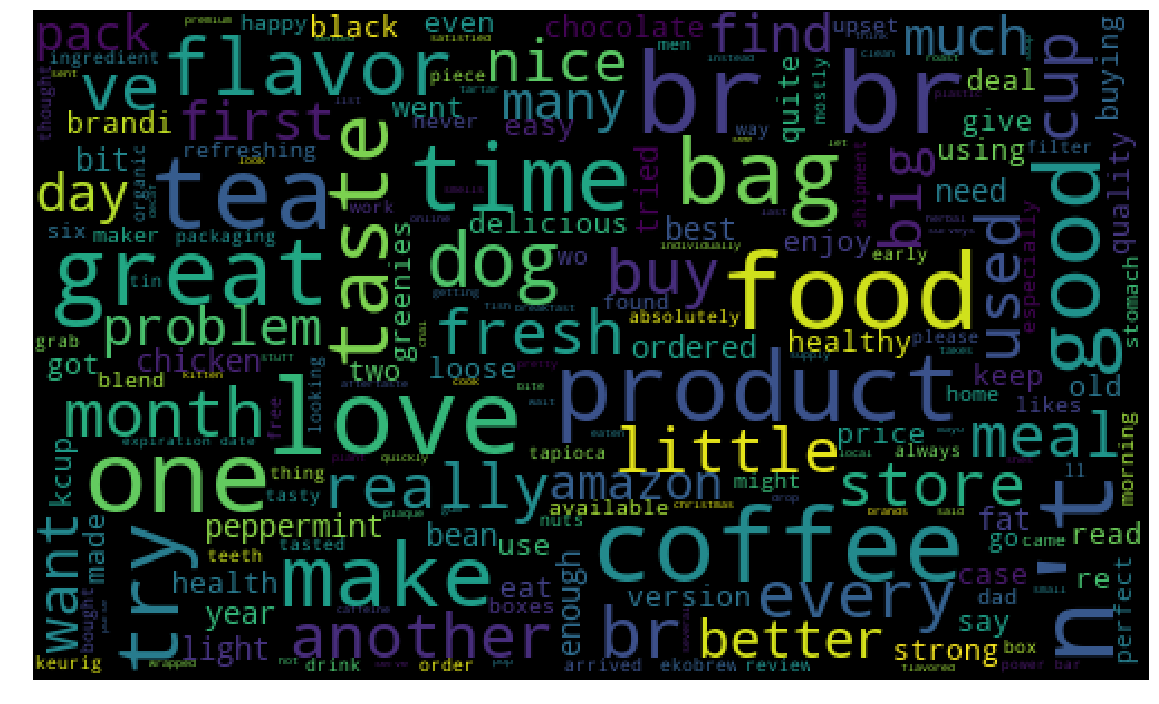

In [52]:
create_word_cloud(sentiment=1)

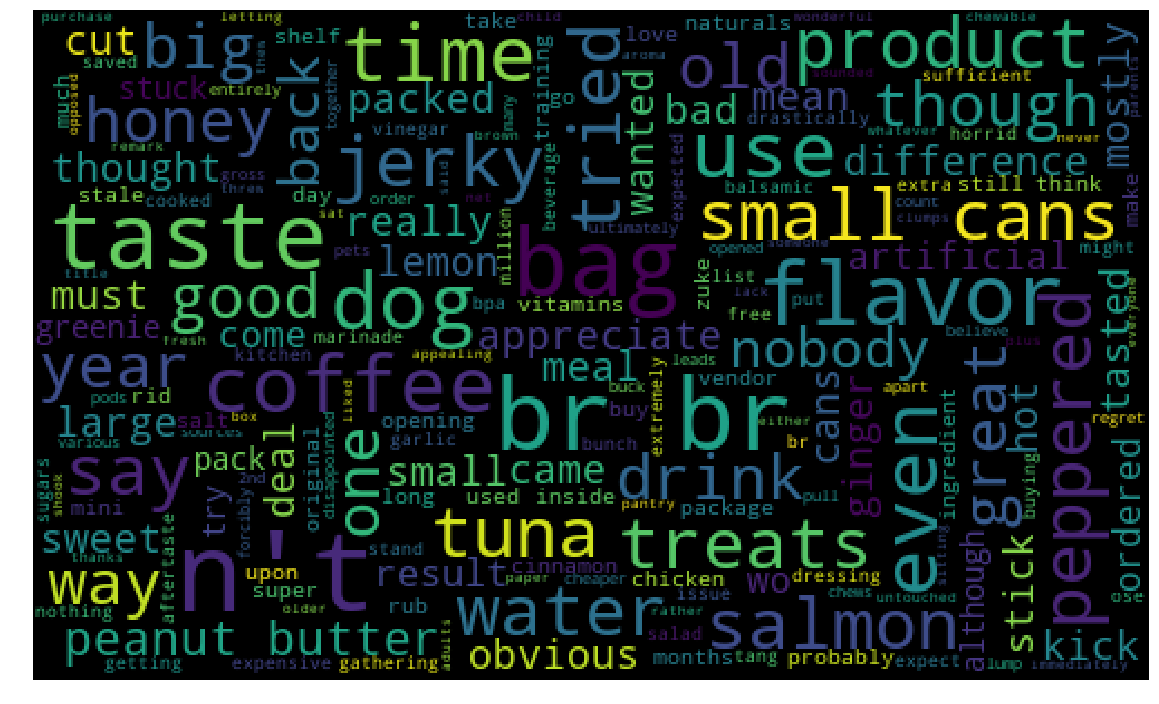

In [53]:
create_word_cloud(sentiment=0)